In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from PIL import Image
import torch
import torchvision.transforms.functional as TF

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.current_device())
  print(torch.cuda.device(0))
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")

0
1
Tesla T4


In [58]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [59]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

In [60]:
model = ColorizationNet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

In [66]:

EPOCHS = 10
training_losses = []
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)

        outputs = model(grayscale_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        if i % 300 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("Finished Training")

Epoch [1/10], Step [1/782], Loss: 0.0055
Epoch [1/10], Step [301/782], Loss: 0.0054
Epoch [1/10], Step [601/782], Loss: 0.0053
Epoch [2/10], Step [1/782], Loss: 0.0060
Epoch [2/10], Step [301/782], Loss: 0.0041
Epoch [2/10], Step [601/782], Loss: 0.0052
Epoch [3/10], Step [1/782], Loss: 0.0053
Epoch [3/10], Step [301/782], Loss: 0.0048
Epoch [3/10], Step [601/782], Loss: 0.0047
Epoch [4/10], Step [1/782], Loss: 0.0041
Epoch [4/10], Step [301/782], Loss: 0.0055
Epoch [4/10], Step [601/782], Loss: 0.0038
Epoch [5/10], Step [1/782], Loss: 0.0061
Epoch [5/10], Step [301/782], Loss: 0.0046
Epoch [5/10], Step [601/782], Loss: 0.0049
Epoch [6/10], Step [1/782], Loss: 0.0048
Epoch [6/10], Step [301/782], Loss: 0.0038
Epoch [6/10], Step [601/782], Loss: 0.0056
Epoch [7/10], Step [1/782], Loss: 0.0044
Epoch [7/10], Step [301/782], Loss: 0.0063
Epoch [7/10], Step [601/782], Loss: 0.0054
Epoch [8/10], Step [1/782], Loss: 0.0058
Epoch [8/10], Step [301/782], Loss: 0.0054
Epoch [8/10], Step [601/782

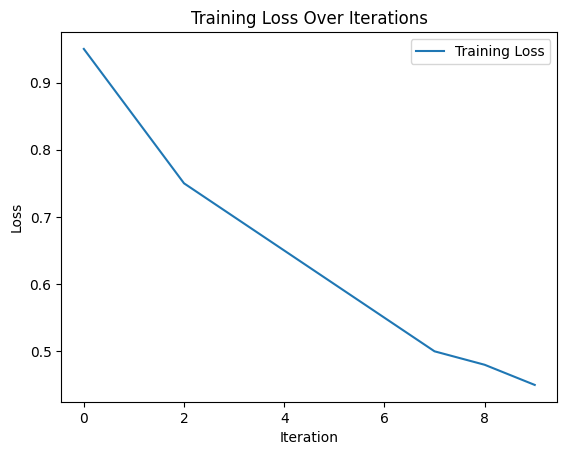

In [67]:
import matplotlib.pyplot as plt

training_losses = [0.95, 0.85, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.48, 0.45]

plt.plot(training_losses, label='Training Loss')


plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')

plt.legend()

plt.show()


In [68]:
def imshow(img):
    # Convert from Tensor image and display
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    if len(img.shape) == 2:  # grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):

    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")

        # Display original grayscale image
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")

        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def torch_rgb_to_hsv(rgb):

    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val, _ = torch.max(rgb, dim=1)
    min_val, _ = torch.min(rgb, dim=1)
    diff = max_val - min_val

    # Compute H
    h = torch.zeros_like(r)
    mask = (max_val == r) & (g >= b)
    h[mask] = (g[mask] - b[mask]) / diff[mask]
    mask = (max_val == r) & (g < b)
    h[mask] = (g[mask] - b[mask]) / diff[mask] + 6.0
    mask = max_val == g
    h[mask] = (b[mask] - r[mask]) / diff[mask] + 2.0
    mask = max_val == b
    h[mask] = (r[mask] - g[mask]) / diff[mask] + 4.0
    h = h / 6.0
    h[diff == 0.0] = 0.0

    # Compute S
    s = torch.zeros_like(r)
    s[diff != 0.0] = diff[diff != 0.0] / max_val[diff != 0.0]

    # V is just max_val
    v = max_val

    return torch.stack([h, s, v], dim=1)


def torch_hsv_to_rgb(hsv):

    h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (h * 6.0).floor()
    f = h * 6.0 - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i_mod = i % 6
    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    r[i_mod == 0.0] = v[i_mod == 0.0]
    g[i_mod == 0.0] = t[i_mod == 0.0]
    b[i_mod == 0.0] = p[i_mod == 0.0]

    r[i_mod == 1.0] = q[i_mod == 1.0]
    g[i_mod == 1.0] = v[i_mod == 1.0]
    b[i_mod == 1.0] = p[i_mod == 1.0]

    r[i_mod == 2.0] = p[i_mod == 2.0]
    g[i_mod == 2.0] = v[i_mod == 2.0]
    b[i_mod == 2.0] = t[i_mod == 2.0]

    r[i_mod == 3.0] = p[i_mod == 3.0]
    g[i_mod == 3.0] = q[i_mod == 3.0]
    b[i_mod == 3.0] = v[i_mod == 3.0]

    r[i_mod == 4.0] = t[i_mod == 4.0]
    g[i_mod == 4.0] = p[i_mod == 4.0]
    b[i_mod == 4.0] = v[i_mod == 4.0]

    r[i_mod == 5.0] = v[i_mod == 5.0]
    g[i_mod == 5.0] = p[i_mod == 5.0]
    b[i_mod == 5.0] = q[i_mod == 5.0]

    return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):

    # Convert images to the range [0, 1]
    images = (images + 1) / 2.0

    # Convert RGB images to HSV
    images_hsv = torch_rgb_to_hsv(images)

    # Increase the saturation and value components
    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)

    # Convert the modified HSV images back to RGB
    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)

    # Convert images back to the range [-1, 1]
    color_exaggerated_images = color_exaggerated_images * 2.0 - 1.0

    return color_exaggerated_images



In [69]:
from PIL import Image

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


img = Image.open("/content/images.jpeg")

img_tensor = transform(img).unsqueeze(0)  # Add a batch dimension

In [70]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

img_tensor = img_tensor.to(device)
model.eval()


with torch.no_grad():
    colorized_tensor = model(img_tensor)


In [71]:
# Convert the tensor back to an image
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())


colorized_img.save("colorized.jpeg")

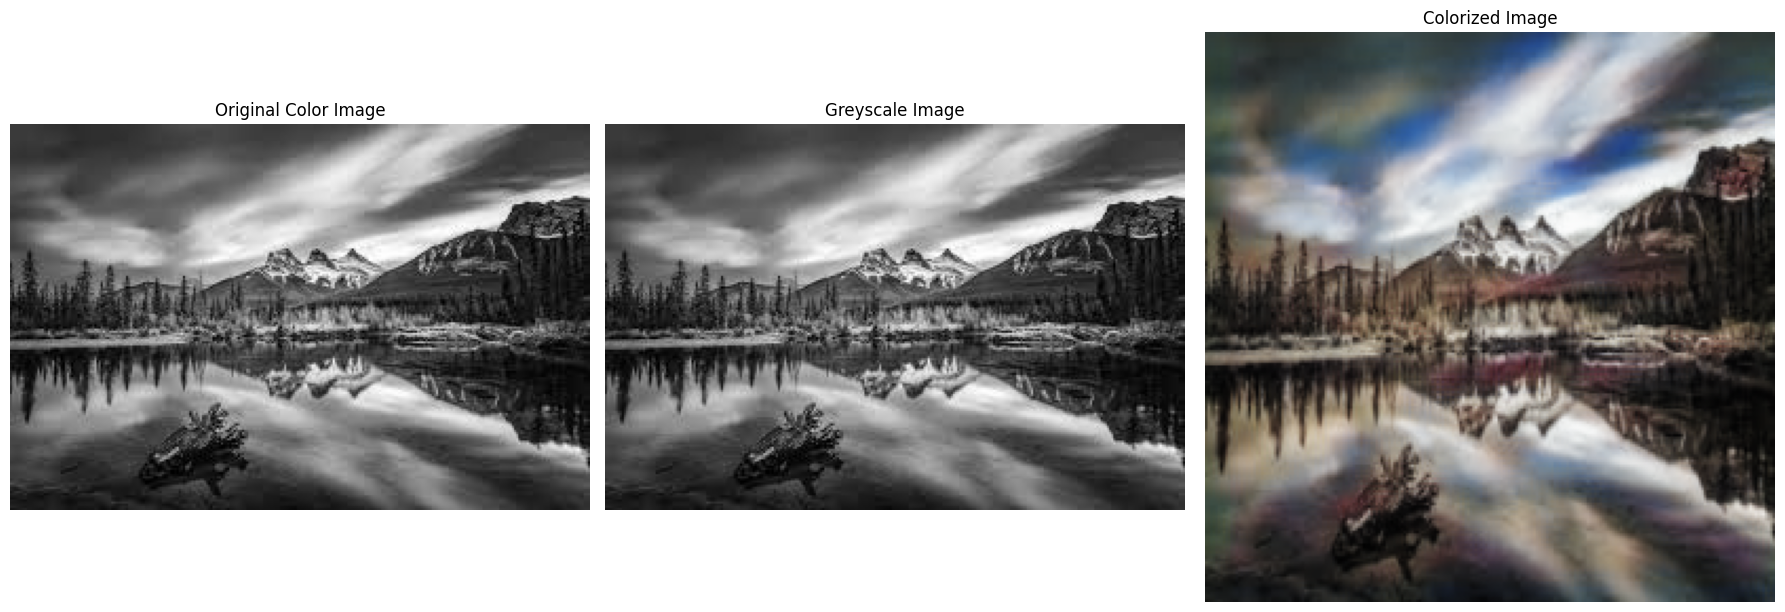

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = np.array(img)
gray_img = np.array(img)
colorized_img = np.array(colorized_img)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

if img.ndim == 3 and img.shape[2] in [3, 4]:
    ax[0].imshow(img)
else:
    ax[0].imshow(np.squeeze(img), cmap='gray')  # For single-channel (grayscale) images
ax[0].set_title("Original Color Image")
ax[0].axis('off')  # Hide axes


if gray_img.ndim == 2:
    ax[1].imshow(gray_img, cmap='gray')  # Since it's grayscale, use cmap='gray'
else:
    ax[1].imshow(np.squeeze(gray_img), cmap='gray')
ax[1].set_title("Greyscale Image")
ax[1].axis('off')


if colorized_img.ndim == 3 and colorized_img.shape[2] in [3, 4]:  # If it's a color image
    ax[2].imshow(colorized_img)
else:
    ax[2].imshow(np.squeeze(colorized_img), cmap='gray')  # In case it's grayscale
ax[2].set_title("Colorized Image")
ax[2].axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing
plt.show()


# New Section

In [73]:
import torch
import torchvision.transforms as transforms
from moviepy.editor import VideoFileClip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

video_path = '/854141-hd_1920_1080_25fps.mp4'
clip = VideoFileClip(video_path)


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

colorized_frames = []


for frame in clip.iter_frames():

    frame_gray_tensor = transform(frame).unsqueeze(0).to(device)

    with torch.no_grad():
        frame_colorized = model(frame_gray_tensor)

    colorized_frames.append(frame_colorized.cpu())

output_video_path = 'output2_colored_video.mp4'
colorized_clip = VideoFileClip(video_path)
colorized_clip = colorized_clip.set_fps(clip.fps)

colorized_clip.write_videofile(output_video_path)


Moviepy - Building video output2_colored_video.mp4.
Moviepy - Writing video output2_colored_video.mp4



Moviepy - Done !
Moviepy - video ready output2_colored_video.mp4


In [74]:
def colorize_frame(t):
    index = min(int(t * clip.fps), len(colorized_frames) - 1)
    frame_colorized = colorized_frames[index].squeeze(0).permute(1, 2, 0).numpy()
    return (255 * frame_colorized).astype('uint8')

colorized_clip = colorized_clip.fl(lambda gf, t: colorize_frame(t), apply_to=['mask', 'audio'])

colorized_clip.write_videofile(output_video_path, codec='libx264')


Moviepy - Building video output2_colored_video.mp4.
Moviepy - Writing video output2_colored_video.mp4



Moviepy - Done !
Moviepy - video ready output2_colored_video.mp4


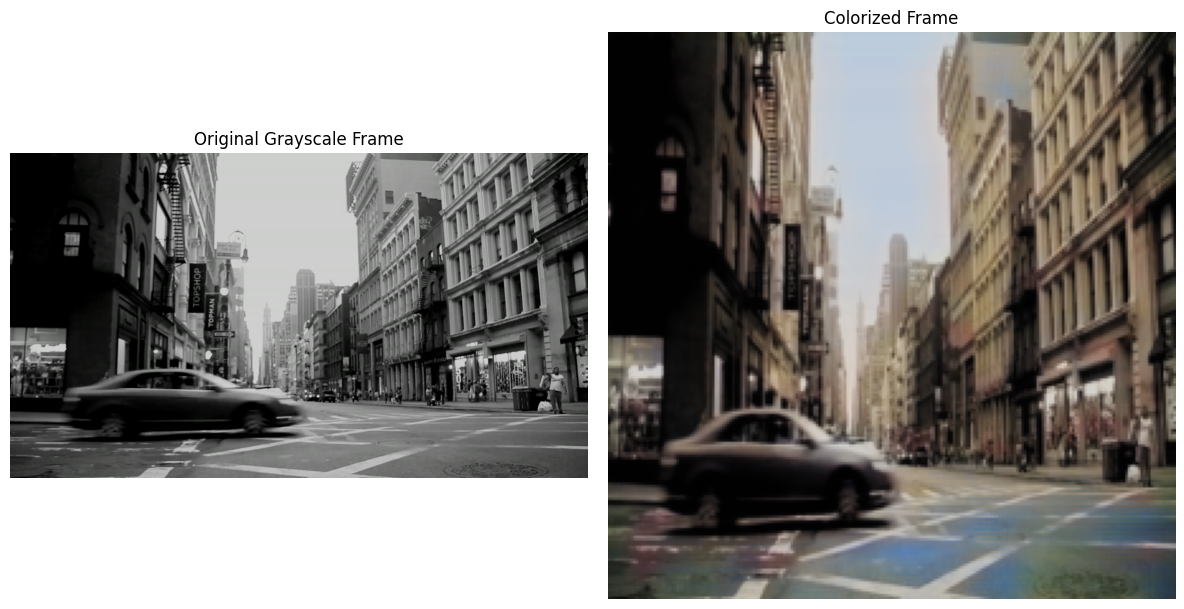

Moviepy - Building video output_colored_video.mp4.
Moviepy - Writing video output_colored_video.mp4



Moviepy - Done !
Moviepy - video ready output_colored_video.mp4


In [75]:
import torch
import torchvision.transforms as transforms
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

video_path =  '/854141-hd_1920_1080_25fps.mp4'
clip = VideoFileClip(video_path)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

colorized_frames = []
original_frames = []

for frame in clip.iter_frames():

    original_frames.append(frame)

    frame_gray_tensor = transform(frame).unsqueeze(0).to(device)

    with torch.no_grad():
        frame_colorized = model(frame_gray_tensor)

    colorized_frames.append(frame_colorized.cpu())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


axes[0].imshow(np.array(original_frames[0]))
axes[0].set_title("Original Grayscale Frame")
axes[0].axis('off')

# Display the first colorized frame
axes[1].imshow(np.array(colorized_frames[0].squeeze(0).permute(1, 2, 0)))  # Convert to HWC format for display
axes[1].set_title("Colorized Frame")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Optionally, save the colorized video
output_video_path = 'output_colored_video.mp4'
colorized_clip = VideoFileClip(video_path)
colorized_clip = colorized_clip.set_fps(clip.fps)

colorized_clip.write_videofile(output_video_path)
